# W266 Final Project: Natural Language Processing on Wine Reviews 
Maria Corina Cabezas, Austin Doolitle

## Background

In [1]:
#add introduction

## Prerequisite Libraries

In [1]:
import random
import math
import collections
import os
import string
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from yellowbrick.regressor import PredictionError
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import keras
import keras_bert
from keras_radam import RAdam
from gensim.models import word2vec
from gensim.models import Word2Vec

seed = 42
random.seed(seed)
np.random.seed(42)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.keras.backend.set_session(tf.Session(config=config));

[nltk_data] Downloading package punkt to /home/austin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


## Data Exploration and Analysis

### Data Cleaning

In [2]:
# Read the data
df = pd.read_csv('./data/winemag-data-130k-v2.zip', index_col=0)
print(f'N Rows: {len(df.index)}')
df.head()

N Rows: 129971


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


The dataset contains a lot of duplicates. I noticed that simply running data.drop_duplicates() did not remove all of them, because some column values were slightly different. Nevertheless, the fact that the "Description" columns were identical was sufficient to determine these were not different reviews. I decided to drop all duplicates based on the description column alone.

In [3]:
df = df.drop_duplicates('description')
print(f'N Rows: {len(df.index)}')

N Rows: 119955


Let's look at the number of missing values on each column

In [4]:
df.isnull().sum(axis = 0)

country                     59
description                  0
designation              34532
points                       0
price                     8388
province                    59
region_1                 19558
region_2                 73195
taster_name              24912
taster_twitter_handle    29441
title                        0
variety                      1
winery                       0
dtype: int64

It makes sense to delete the columns that have a very large number of missing values like designation, region_2 and taster_twitter_handle

In [5]:
columns = ['designation','region_2','taster_twitter_handle']
df = df.drop(columns, axis=1)

## Train/Test/Dev Split

 First we split our dataset into 3 sets, namely training set, dev set, and test set. This is so that we can be more confident at our models and to better compare the model options we come up with. Specifically, training set is used to train our models, dev set is used to optimize each model, and test set is used to evaluate performance of the model. We have assigned 20% of the total dataset to be the test set, 20% to be the dev set, and the rest being training set. We made the split here because it will be used in the Data Exploration.

In [6]:
# split it into train, dev, and test
# courtesy of https://stackoverflow.com/a/38251063
perm = np.random.permutation(df.index)
m = len(df.index)

train_percent = .6
dev_percent = .2

train_end = int(m * train_percent)
dev_end = int(m * dev_percent) + train_end

train_df = df.loc[perm[:train_end]]
dev_df = df.loc[perm[train_end:dev_end]]
test_df = df.loc[perm[dev_end:]]

print(f'Train shape: {train_df.shape}')
print(f'Dev shape: {dev_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (71973, 10)
Dev shape: (23991, 10)
Test shape: (23991, 10)


## Initial Investigation
Let's start by just looking at the data and seeing what pops out to us. We'll spend a little time looking at the continuous values points and price, and then spend more time looking at the words

In [7]:
train_df.describe(include='all')

,country,description,points,price,province,region_1,taster_name,title,variety,winery
count,71934,71973,71973.000000,66960.000000,71934,60248,56995,71973,71972,71973
unique,41,71973,NaN,NaN,387,1135,19,71515,627,14262
top,US,"This blend of 50% Grenache, 25% Syrah and 25% ...",NaN,NaN,California,Napa Valley,Roger Voss,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,30183,1,NaN,NaN,20167,2536,14186,8,7319,122
mean,NaN,NaN,88.444625,35.719355,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,3.094782,42.384790,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Points

It appears that the points are located between 80-100. This matches up with the source of the data that claims they do not publish reviews for any wine scored less than 80. More information on wine scoring can be viewed [here](https://www.winespectator.com/articles/scoring-scale)

Text(0.5, 1.0, 'Review Points Distribution')

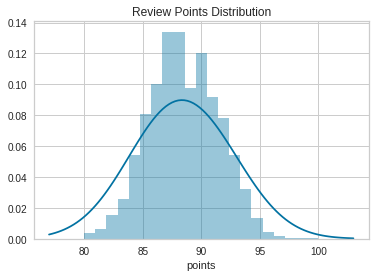

In [9]:
_=ax = sns.distplot(train_df.points, bins=21, kde_kws={'bw':1})
ax.set_title('Review Points Distribution')

So it looks like this is a textbook normal distribution with an incredibly slight left skew. Let's just make sure that every value is represented.

In [10]:
print(np.sort(train_df.points.unique()))

[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]


### Price

Since this is related to currency, I bet my lunch this is a heavy tailed distribution. Let's see.

Missing values: 5013


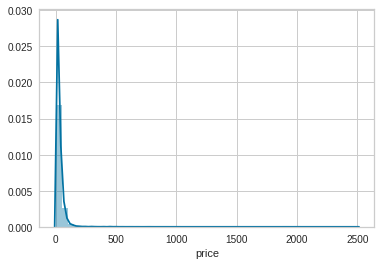

In [11]:
print(f'Missing values: {train_df.price.isna().sum()}')

# let's remove the missing prices for now
sns.distplot(train_df[~train_df.price.isna()].price)

Nice... lets log scale this.

Text(0.5, 1.0, 'Log-Price Distribution')

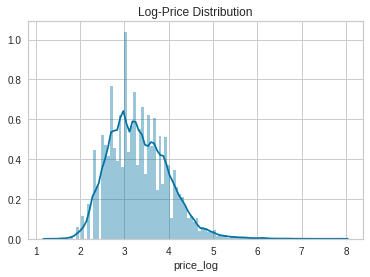

In [8]:
train_df['price_log'] = np.log(train_df.price)
ax = sns.distplot(train_df[~train_df.price_log.isna()].price_log, bins=100)
ax.set_title("Log-Price Distribution")

Just out of curiosity, I see that the lowest price is 4 dollars... what's the score on those?

In [13]:
train_df[train_df.price == 4].points.mean()

84.0

### String Columns

In [14]:
non_cont_columns = train_df.columns[train_df.dtypes == np.object]
print(f'Non-Continuous columns: {list(non_cont_columns)}')

Non-Continuous columns: ['country', 'description', 'province', 'region_1', 'taster_name', 'title', 'variety', 'winery']


Let's start by focusing on the descriptions. We'll tokenize, canonize, construct a vocabulary, and finally get counts for each of the items.

In [13]:
# collect the top 10 words from the corpus (not including nltk stop words)
def get_top_counts(X, vec):
    counts = np.array(np.sum(X, axis=0))[0]
    vocab_inv = {k: counts[v] for k, v in vec.vocabulary_.items()}
    return vocab_inv

def get_most_common(counts_dict, n=None):
    words = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    
    counts_sorted_idx = np.argsort(counts)[::-1]
    if n:
        counts_sorted_idx = counts_sorted_idx[:n]
        
    return words[counts_sorted_idx], counts[counts_sorted_idx]

default_stop_words = stopwords.words('english')
top_domain_specific_words = []
n = 10

vec = CountVectorizer(
    lowercase=True,
    stop_words=default_stop_words,
    ngram_range=(1, 1,),
    min_df=10
)
X =  vec.fit_transform(train_df.description)

temp_counts = get_top_counts(X, vec)
most_common_words, most_common_counts = get_most_common(temp_counts, n=n)
        
stop_words = list(most_common_words) + default_stop_words + list(string.punctuation)
stop_words = set(stop_words)

latex_escapes = "&%$#_{}~^\\"
print("[", end='')
for w in stop_words:
    if w in latex_escapes:
        w = '\\' + w
    
    print('"' + w + '", ', end='')

print(']')

["same", "-", "\^", "only", "won", "now", "\%", "very", "ma", "s", "don", "\}", "be", "their", "for", "under", ".", "[", "not", "some", "did", "m", "any", "so", "or", "he", "t", "\&", "can", "y", ";", "don't", "why", "weren", "up", "because", "at", "\#", "hadn't", "we", "=", ")", "here", "you're", "does", "doesn", "?", "'", "on", "yourselves", "his", "more", "palate", "couldn", "themselves", "+", "(", "fruit", "its", "itself", "those", "that'll", "above", "shan", "won't", "wouldn", "being", "flavors", "if", "her", "when", "of", """, "ain", "\\", "o", "`", "wasn't", "wouldn't", "have", "isn't", "whom", "aren", "mustn", "before", "haven't", "through", "ve", "shouldn", "tannins", "haven", "than", "was", "where", "in", "doesn't", "you've", "him", "himself", "been", "you'll", "needn", "you'd", "aromas", "each", "mightn't", "this", "both", "while", "ll", "d", "these", "again", "all", "mightn", "the", "ourselves", "few", "should've", "until", "hasn't", "weren't", "during", "!", "wasn", "hers"

In [11]:
def get_vec(data, **kwargs):
    vec = CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        **kwargs
    )
    return vec.fit_transform(data), vec
        
def print_top_counts(X, vec, title='Top Counts', n=10):
    vocab_counts = get_top_counts(X, vec)
    
    vocab, counts = get_most_common(vocab_counts, n=n)
    print(title)
    for v, c in zip(vocab, counts):
        print(f'\t{v}: {c}')

In [17]:
for i in range(1,4):
    X, vec = get_vec(train_df.description, ngram_range=(i,i))
    vocab = vec.vocabulary_.values()
    print(f'{i}-gramLength of vocab: {len(vocab)}\n')

    print_top_counts(X, vec)

X, vec = get_vec(train_df.description, ngram_range=(1,3))
vocab = vec.vocabulary_.values()
print(f'{i}-gramLength of vocab: {len(vocab)}\n')

print_top_counts(X, vec)

1-gramLength of vocab: 25771

Top Counts
	black: 15967
	ripe: 14979
	red: 11949
	spice: 10658
	notes: 10438
	oak: 9855
	rich: 9785
	dry: 9567
	fresh: 9541
	berry: 9478
2-gramLength of vocab: 597170

Top Counts
	full bodied: 3786
	cabernet sauvignon: 2931
	medium bodied: 1794
	pinot noir: 1757
	red berry: 1710
	black currant: 1707
	black pepper: 1574
	black plum: 1411
	white pepper: 1373
	cabernet franc: 1333
3-gramLength of vocab: 1222724

Top Counts
	new french oak: 436
	red berry fruits: 381
	blend cabernet sauvignon: 322
	cabernet sauvignon merlot: 309
	merlot cabernet sauvignon: 228
	merlot cabernet franc: 203
	offers dried black: 188
	roasted coffee bean: 185
	black currant fruits: 174
	blackberry black currant: 169
3-gramLength of vocab: 1845665

Top Counts
	black: 15967
	ripe: 14979
	red: 11949
	spice: 10658
	notes: 10438
	oak: 9855
	rich: 9785
	dry: 9567
	fresh: 9541
	berry: 9478


One very interesting thing viewed here is that in the most common words are very wine specific words. This is pretty obvious in hindsight, but it made me laugh to see wine just outside of the top 10.

Now we would like to see a wordcloud view of the most common words excluding punctuations and stopwords. We also excluded other common words like drink, wine, flavors etc.

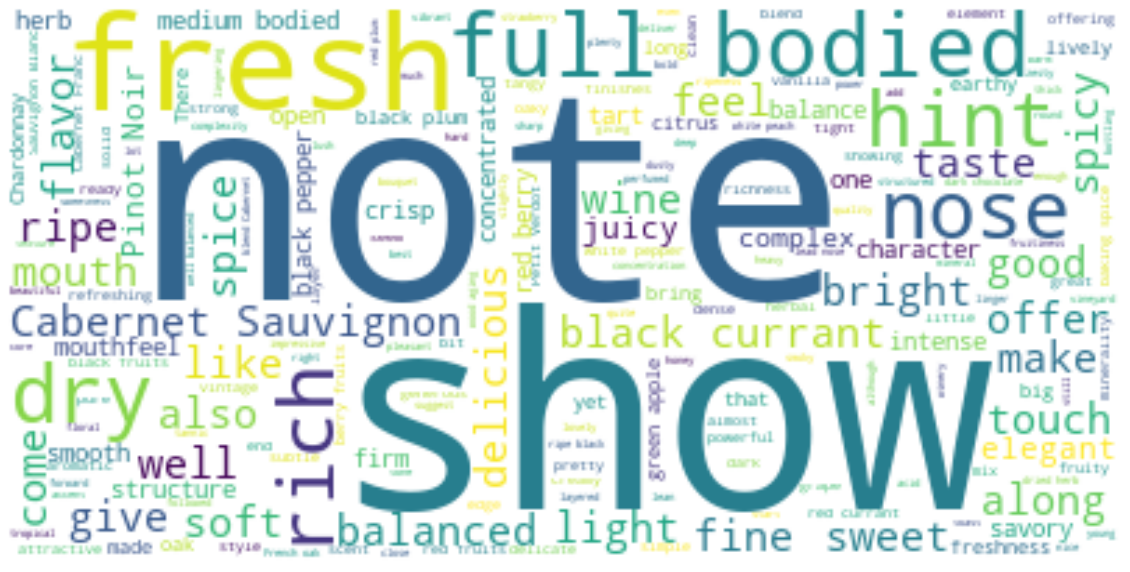

In [18]:
text = " ".join(review for review in train_df.description)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It seems black cherry and full bodied are the most common characteristics and Carbernet Sauvignon is the most discussed type of wine. Let's see if this is due to it being more common in the dataset

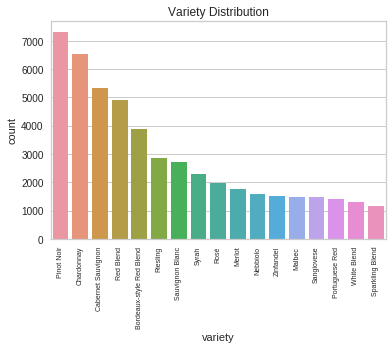

In [19]:
variety_df = train_df.groupby('variety').filter(lambda x: len(x) > 1000)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (6, 4))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
ax.set_title('Variety Distribution')
plt.xticks(rotation = 90, fontsize=7)
plt.show()


Surprisingly, Cabernet Sauvignon was the third most reviewed wine variety after Pinot Noir and Chardonnay.

### Tasters
Now let's look at the tasters. We'll see how many there are, and the distribution of the number of reviews each has given

19 Tasters: ['Michael Schachner', 'Joe Czerwinski', 'Roger Voss', 'Anne Krebiehl\xa0MW', 'Sean P. Sullivan', 'Paul Gregutt', 'Virginie Boone', 'Carrie Dykes', 'Kerin O’Keefe', 'Anna Lee C. Iijima', 'Matt Kettmann', 'Jim Gordon', 'Lauren Buzzeo', 'Mike DeSimone', 'Susan Kostrzewa', 'Jeff Jenssen', 'Alexander Peartree', 'Fiona Adams', 'Christina Pickard']


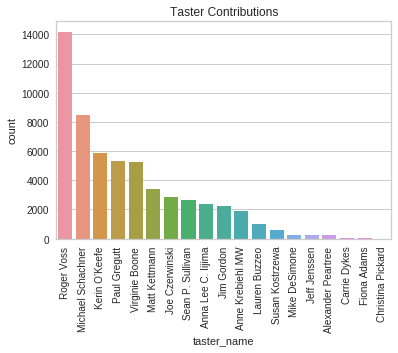

In [20]:
tasters = train_df.taster_name.dropna().unique()
print(f'{len(tasters)} Tasters: {list(tasters)}')
train_df.taster_name = train_df.taster_name.astype('category')

taster_counts  = train_df.taster_name.value_counts()
ax = sns.countplot(train_df.taster_name, order=taster_counts.index)
ax.set_title('Taster Contributions')
_ = ax.set_xticklabels(taster_counts.index, rotation=90)

As expected, there appears to be a Zeta distribution in the contributions of each taster. Let's what the numbers are on the 3 least active contributors: Carrie Dykes, Fiona Adams, and Christina Pickard.

In [21]:
print(taster_counts[['Carrie Dykes', 'Fiona Adams', 'Christina Pickard']])

Carrie Dykes         69
Fiona Adams          16
Christina Pickard     3
Name: taster_name, dtype: int64


We'll need to keep this in mind for subsequent analysis since the data related to their contributions will likely not be as representative as someone on the center or left of the distribution

#### Taster Vocabulary
Just for funsies, let's look at the vocabulary of each individual taster

In [22]:
taster_vocabs = {}
for taster in tasters:
    taster_descriptions = train_df[train_df.taster_name == taster].description
    taster_vocabs[taster] = get_vec(taster_descriptions, ngram_range=(1,1))

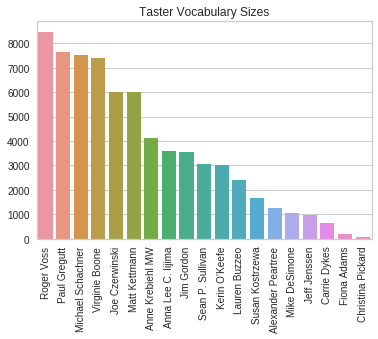

In [23]:
taster_vocab_lens = {k: len(v.vocabulary_.keys()) for k, (x, v) in taster_vocabs.items()}
taster_vocab_lens = pd.Series(taster_vocab_lens).sort_values().iloc[::-1]

ax = sns.barplot(x=taster_vocab_lens.index, y=taster_vocab_lens)
ax.set_title("Taster Vocabulary Sizes")
_ = ax.set_xticklabels(taster_vocab_lens.index, rotation=90)

As expected, Roger Voss is up top since he has had the most opportunity to use unique words. Let's compare the two lists.

In [24]:
compare_list = []

contribution_count_list = list(taster_counts.index)

print('Vocab Size compared to Contribution:')
for vocab_idx, taster in enumerate(taster_vocab_lens.index):
    count_idx = contribution_count_list.index(taster)
    diff = count_idx - vocab_idx
    print(f'\t{vocab_idx + 1}: {taster} ({diff:+d})')

Vocab Size compared to Contribution:
	1: Roger Voss (+0)
	2: Paul Gregutt (+2)
	3: Michael Schachner (-1)
	4: Virginie Boone (+1)
	5: Joe Czerwinski (+2)
	6: Matt Kettmann (+0)
	7: Anne Krebiehl MW (+4)
	8: Anna Lee C. Iijima (+1)
	9: Jim Gordon (+1)
	10: Sean P. Sullivan (-2)
	11: Kerin O’Keefe (-8)
	12: Lauren Buzzeo (+0)
	13: Susan Kostrzewa (+0)
	14: Alexander Peartree (+2)
	15: Mike DeSimone (-1)
	16: Jeff Jenssen (-1)
	17: Carrie Dykes (+0)
	18: Fiona Adams (+0)
	19: Christina Pickard (+0)


Kerin O'Keefe appears to be relatively bland in her word usage. 

#### Taster Score Distribution
Let's look at each reviewer's score distribution to make sure we don't have any biased reviewers

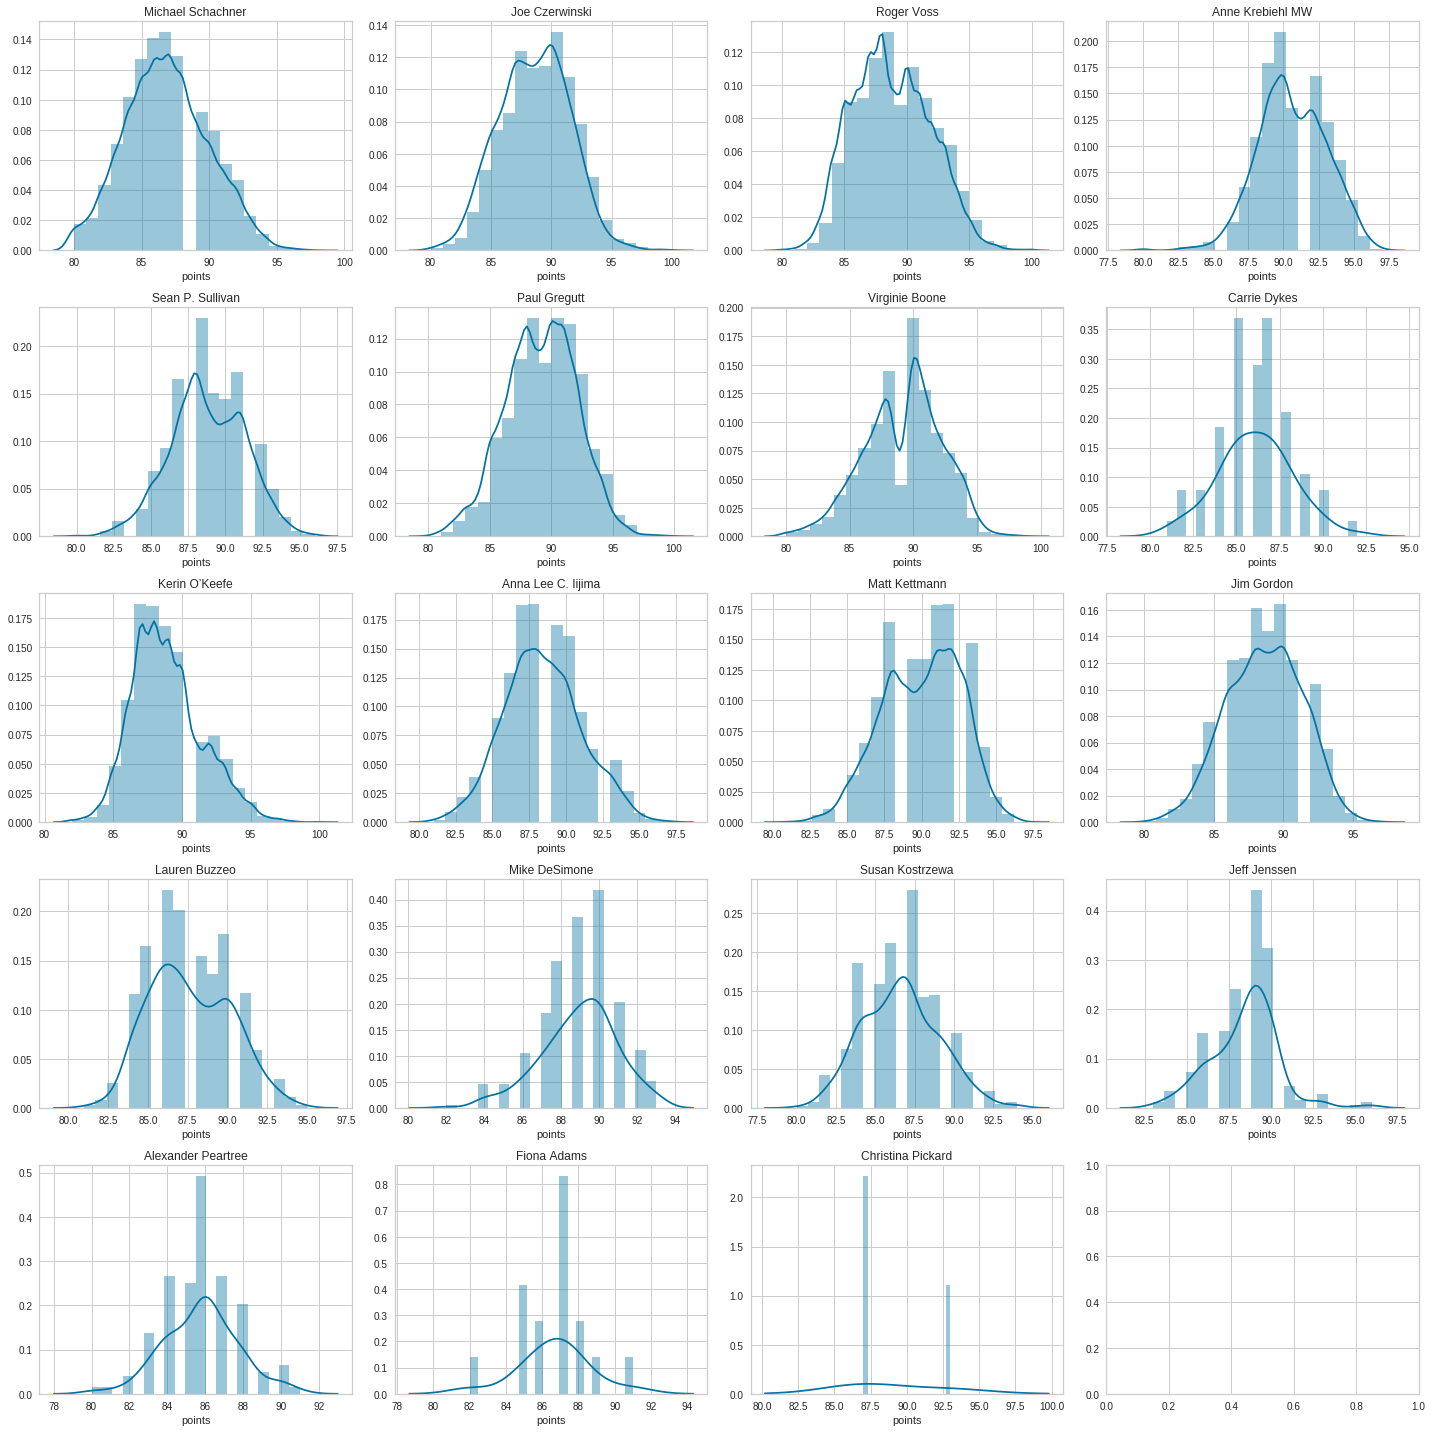

In [25]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[train_df.taster_name == taster]
    ax = sns.distplot(taster_reviews.points, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

There isn't any bias immediately apparent for any of the reviewers, although this is difficult to ascertain due to the large range in the number of reviews per taster.

#### Taster Price Distribution

And now let's look at the distribution of the log price for each reviewer

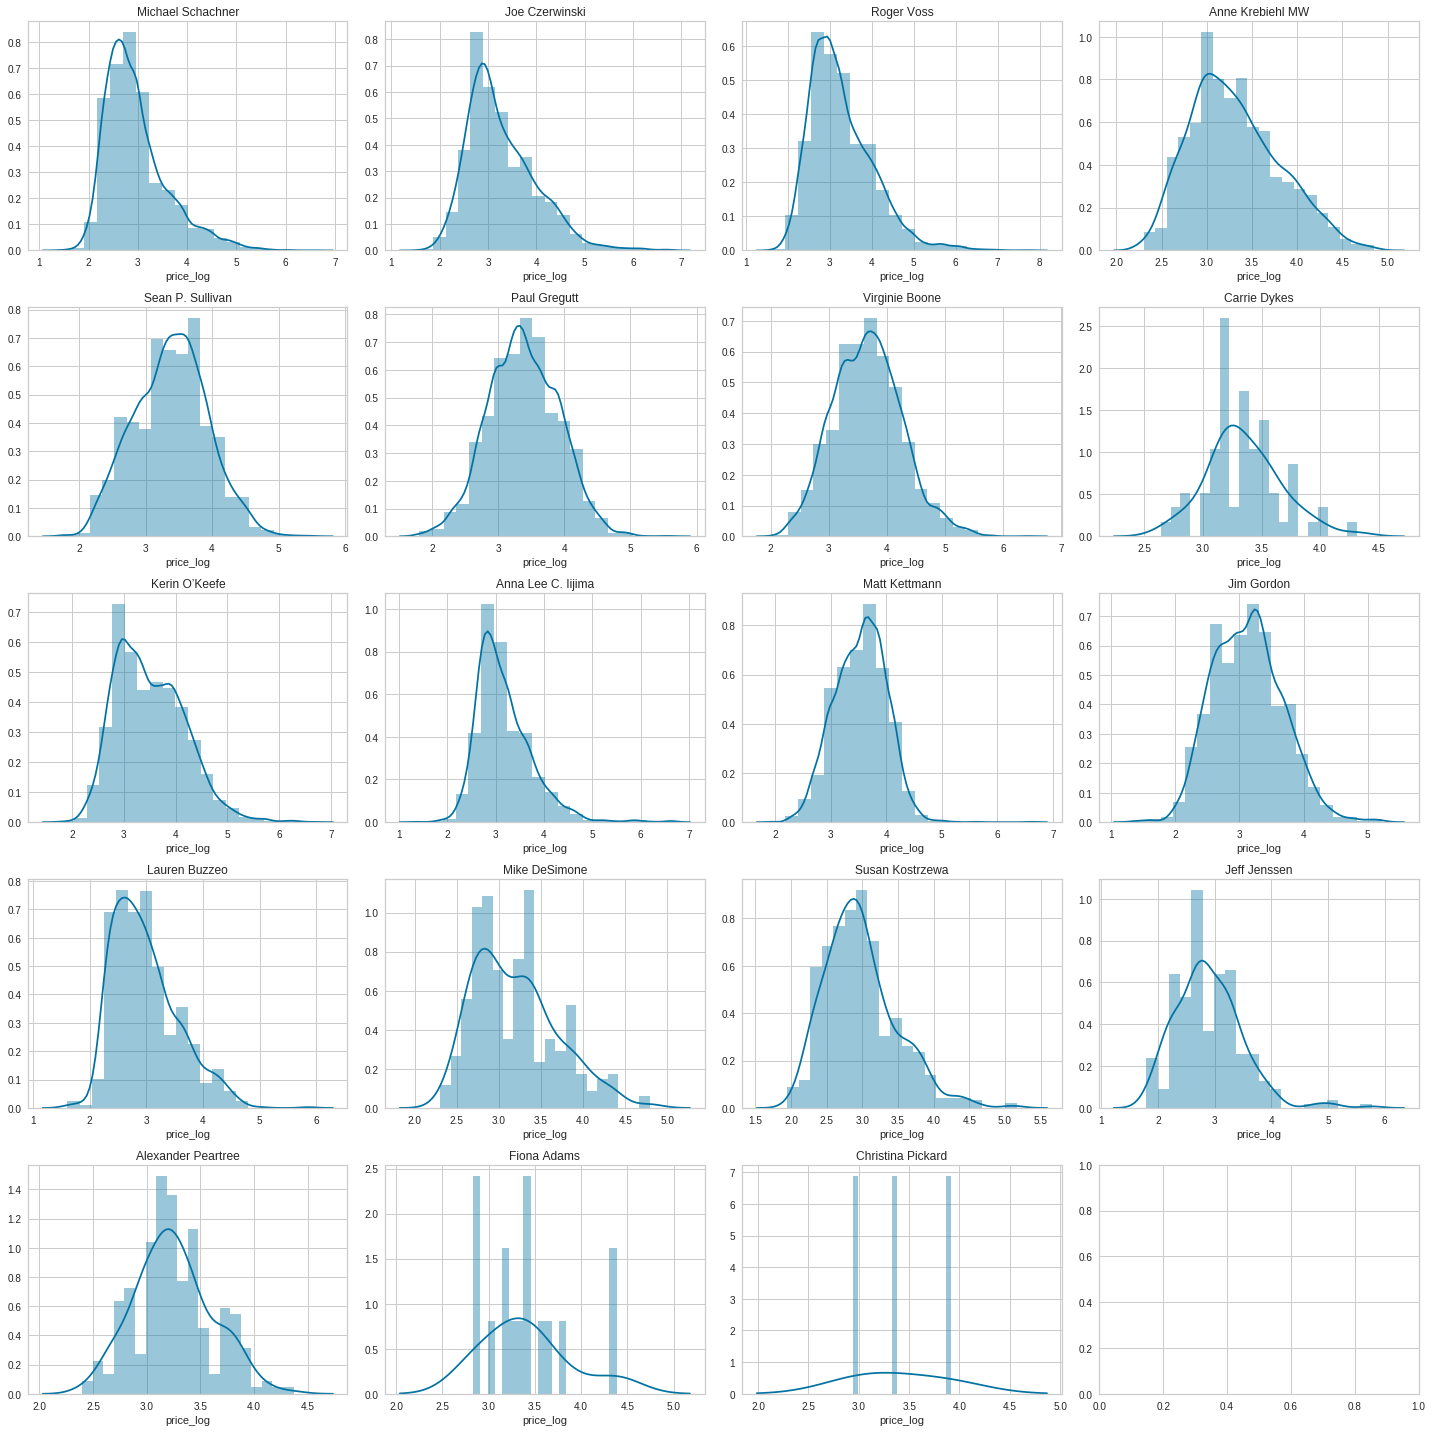

In [26]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[(train_df.taster_name == taster) & ~train_df.price_log.isna()]
    ax = sns.distplot(taster_reviews.price_log, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

### Unique Words
Let's look at the top 3 unique words used by the tasters. We'll do this by iteratively constructing of the top 3 words used by each taster and removing any duplicate words across top 3 lists.

In [27]:
n = 3
for taster_name in taster_vocabs.keys():
    taster_X, vec = taster_vocabs[taster_name]
    print_top_counts(taster_X, vec, title=f'{taster_name} counts:', n=n)

Michael Schachner counts:
	berry: 3599
	plum: 2916
	oak: 1987
Joe Czerwinski counts:
	notes: 993
	bodied: 879
	hints: 627
Roger Voss counts:
	ripe: 5624
	fruits: 5056
	rich: 3865
Anne Krebiehl MW counts:
	nose: 1000
	notes: 810
	freshness: 779
Sean P. Sullivan counts:
	notes: 1016
	spice: 772
	cabernet: 667
Paul Gregutt counts:
	light: 780
	black: 774
	oak: 745
Virginie Boone counts:
	oak: 1496
	black: 1324
	bodied: 1139
Carrie Dykes counts:
	nose: 30
	notes: 24
	long: 24
Kerin O’Keefe counts:
	black: 3109
	offers: 2494
	alongside: 2436
Anna Lee C. Iijima counts:
	dry: 916
	notes: 802
	riesling: 753
Matt Kettmann counts:
	nose: 2539
	black: 1733
	bottling: 1309
Jim Gordon counts:
	texture: 1170
	bodied: 1118
	full: 890
Lauren Buzzeo counts:
	notes: 489
	medium: 392
	black: 375
Mike DeSimone counts:
	black: 183
	bright: 93
	violet: 83
Susan Kostrzewa counts:
	spice: 354
	nose: 307
	red: 205
Jeff Jenssen counts:
	black: 145
	lemon: 113
	red: 86
Alexander Peartree counts:
	nose: 137
	red:

Let's see what words are most strongly correlated with price

In [28]:
def get_corr(x, y):
    y = np.expand_dims(y, axis=0)
    x = x.toarray().T
    points_np = np.concatenate([x, y], axis=0).astype(np.float32)
    return np.corrcoef(points_np)[-1][:-1]

def display_corr(corr, vec, n=10):
    corr_sorted_idx = np.argsort(corr)
    vocab_words = list(vec.vocabulary_.keys())
    
    print('Highest correlations:')
    for i, idx in enumerate(corr_sorted_idx[-1:-n-1:-1]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')

    print('Lowest correlations:')
    for i, idx in enumerate(corr_sorted_idx[:n]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')
    
def run_correlation(data, labels, ngram, min_df=10):
    X, vec = get_vec(data, ngram_range=(ngram, ngram), min_df=min_df)
    X_corr = get_corr(X, labels)
    display_corr(X_corr, vec)
    return X, vec

def get_top_counts(X, vec, n=10):
    counts = np.sum(X, axis=0)
    counts = np.array(counts)[0]    
    counts_sorted_idx = np.argsort(counts)
    
    inverted_vocab = {v: k for k, v in vec.vocabulary_.items()}
    top_counts = counts[counts_sorted_idx[-n:]][::-1]
    top_words = [inverted_vocab[i] for i in counts_sorted_idx[-n:]][::-1]
    
    for word, count in zip(top_words, top_counts):
        print(word, count)

In [29]:
X, vec = run_correlation(train_df.description, train_df.points, 1)
del X
del vec

KeyboardInterrupt: 

In [ ]:
# get_top_counts(test_X, test_vec)
# del test_X
# del test_vec

In [ ]:
train_price_df = train_df.dropna(subset=['price'], axis=0, inplace=False)
dev_price_df = dev_df.dropna(subset=['price'], axis=0, inplace=False)

for df, label in [(train_df, 'score'), (train_price_df, 'price')]:
    for i in range(1, 4):
        X, vec = run_correlation(df.description, df[label], i)
        get_top_counts(X, vec, n=5)

        del X
        del vec
        print()

# NLP Models

## Regression Models

In [14]:
gettysburg_address = "Four score and seven years ago our fathers brought forth on this continent, a new nation, conceived in Liberty, and dedicated to the proposition that all men are created equal."
good_review = "Tantalizing the taste buds, Five Oaks brand chardonnay is truly a taste sensation. Few wines are this full bodied while also leaving some room for the imagination."
bad_review = "Yellow Tail's accessibility makes it quite attractive, however I found the taste to be somewhat metallic and lacking the body of a true chardonnay"

test_sentences = {
    'gettysburg_address': gettysburg_address, 
    'good_review': good_review, 
    'bad_review': bad_review
}

def signorm(d):
    d = np.array(d, dtype=np.float32)
    d_min = d.min()
    return (d - d_min) / (d.max() - d.min())

def zero_mean_norm(d):
    d = np.array(d)
    return (d - d.mean()) / d.std()

def zero_mean_norm_rev(d, original_d):
    return d * original_d.std() + original_d.mean()

# idk how else to do this, I'm so sorry
def plot_predicted_vs_actual(actual_labels, expected_labels):
    sorted_y = np.argsort(actual_labels, axis=0)

    actual_sorted = np.squeeze(actual_labels[sorted_y])
    expected_sorted = np.squeeze(expected_labels[sorted_y])
    temp_df = pd.DataFrame()
    temp_df['counts'] = np.concatenate([actual_sorted, expected_sorted])

    mask = np.concatenate([np.ones_like(actual_sorted), np.zeros_like(expected_sorted)])
    lut = {
        1: 'actual',
        0: 'expected'
    }
    temp_df['mask'] = mask
    temp_df['mask'] = temp_df['mask'].map(lut)

    index = np.tile(np.arange(actual_sorted.shape[0]), 2)
    ax = sns.scatterplot(index, 'counts', hue='mask', data=temp_df)

def train_and_show(model, x, y, x_dev, y_dev):
    visualizer = PredictionError(model)

    model.fit(x, y)  # Fit the training data to the visualizer
    y_dev_predict = model.predict(x_dev)  # Evaluate the model on the test data
#     plot_predicted_vs_actual(y_dev_predict, y_dev)
    
    mse_val = metrics.mean_squared_error(y_dev, y_dev_predict)
    print(f'MSE: {mse_val:.5f}')
    return model

y_train = zero_mean_norm(train_df.points).reshape(-1,1)
y_dev = zero_mean_norm(dev_df.points).reshape(-1, 1)

for i in range(1, 4):
    print('%i gram'%i)
    X_train, vec = get_vec(train_df.description, ngram_range=(i,i))
    X_dev = vec.transform(dev_df.description)
    model = train_and_show(LinearRegression(), X_train, y_train, X_dev, y_dev)
    
    test_sentences_X = vec.transform(test_sentences.values())
    model_out = model.predict(test_sentences_X)
    model_out = zero_mean_norm_rev(model_out, train_df.points)
    print(model_out)

print('1-3 gram')
X_train, vec = get_vec(train_df.description, ngram_range=(1,3))
X_dev = vec.transform(dev_df.description)
linear_model = train_and_show(LinearRegression(), X_train, y_train, X_dev, y_dev)

test_sentences_X = vec.transform(test_sentences.values())
model_out = linear_model.predict(test_sentences_X)
model_out = zero_mean_norm_rev(model_out, train_df.points)
print(model_out)

del X_train
del X_dev
del vec



1 gram


KeyboardInterrupt: 

In [23]:
train_price_df.log_price = np.log10(train_price_df.price)
dev_price_df.log_price = np.log10(dev_price_df.price)

y_train = zero_mean_norm(train_price_df.log_price).reshape(-1,1)
y_dev = zero_mean_norm(dev_price_df.log_price).reshape(-1, 1)

# for i in range(1, 4):
#     print('%i gram'%i)
#     X_train, vec = get_vec(train_price_df.description, ngram_range=(i,i))
#     X_dev = vec.transform(dev_price_df.description)
#     model = train_and_show(LinearRegression(), X_train, y_train, X_dev, y_dev)
    
#     test_sentences_X = vec.transform(test_sentences.values())
#     model_out = model.predict(test_sentences_X)
#     model_out = zero_mean_norm_rev(model_out, train_price_df.log_price)
#     model_out = np.power(model_out, 10)
#     print(model_out)

print('1-3 gram')
X_train, vec = get_vec(train_price_df.description, ngram_range=(1,3))
X_dev = vec.transform(dev_price_df.description)
model = train_and_show(LinearRegression(), X_train, y_train, X_dev, y_dev)

test_sentences_X = vec.transform(test_sentences.values())
model_out = model.predict(test_sentences_X)
model_out = zero_mean_norm_rev(model_out, train_price_df.log_price)
model_out = np.power(model_out, 10)
print(model_out)

del X_train
del X_dev
del vec

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


NameError: name 'dev_price_df' is not defined

In [15]:
# The longest description, including start and end tokens
max_len = 130

def surround_texts(texts):
    return [f'SSS {t} EEE' for t in texts]

t = keras.preprocessing.text.Tokenizer()
surrounded_train = surround_texts(train_df.description)
t.fit_on_texts(surrounded_train)
vocab_size = len(t.word_counts)

def preproc_data(data):
    surrounded_series = surround_texts(data)
    seq = t.texts_to_sequences(surrounded_series)
    pad =  keras.preprocessing.sequence.pad_sequences(
        seq, 
        maxlen=max_len,
        padding='post',
        truncating='post',
    )
    return pad

def get_dataset(data, label):
    """
    FYI setting sigmoid_norm to False normalizes mean to 0 and variance to 1
    Setting to True scales linearly to range [0-1]
    """
    pad = preproc_data(data)
    
    label = np.array(label, dtype=np.float32)
    label_norm = zero_mean_norm(label)
    
    return pad, label_norm

train_points_X, train_points_y = get_dataset(train_df.description, train_df.points)
dev_points_X, dev_points_y = get_dataset(dev_df.description, dev_df.points)
test_points_X, test_points_y = get_dataset(test_df.description, test_df.points)

In [16]:
# create our CNN model
def train_cnn(train_X, train_y, dev_X, dev_y, batch_size=256, embedding_dim=256, lr=1e-4, output_dir='./out/cnn', epochs=15, loss='mean_absolute_error', metrics=['mae']):
    os.makedirs(output_dir, exist_ok=True)

    inputs = keras.layers.Input((max_len,))
    embedding = keras.layers.Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=max_len)(inputs)
    reshape = keras.layers.Reshape((max_len,embedding_dim,1))(embedding)

    conv0_0 = keras.layers.Conv2D(256, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_1 = keras.layers.Conv2D(256, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_2 = keras.layers.Conv2D(256, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool0_0 = keras.layers.MaxPool2D(pool_size=(max_len - 3 + 1, 1), strides=(1,1), padding='valid')(conv0_0)
    maxpool0_1 = keras.layers.MaxPool2D(pool_size=(max_len - 4 + 1, 1), strides=(1,1), padding='valid')(conv0_1)
    maxpool0_2 = keras.layers.MaxPool2D(pool_size=(max_len - 5 + 1, 1), strides=(1,1), padding='valid')(conv0_2)

    concat = keras.layers.Concatenate(axis=1)([maxpool0_0, maxpool0_1, maxpool0_2])
    flatten = keras.layers.Flatten()(concat)
    dropout = keras.layers.Dropout(0.1)(flatten)
    output = keras.layers.Dense(units=1)(dropout)

    model = keras.models.Model(inputs, output)

    chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # TODO try different loss functions
    model.compile(optimizer=adam, loss=loss, metrics=metrics)
    print("Training Model...")
    model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[chkpt], validation_data=(dev_X, dev_y))  # starts training
    return model

In [ ]:
points_model_cnn = train_cnn(train_points_X, train_points_y, dev_points_X, dev_points_y, loss='mean_squared_error', metrics=['mse'], epochs=15)

# test_sentences_X = preproc_data(test_sentences.values())
# model_out = points_model_cnn.predict(test_sentences_X)
# model_out = zero_mean_norm_rev(model_out, train_points_y)
# print(model_out)

In [ ]:
test_sentences_X = preproc_data(test_sentences.values())
model_out = points_model_cnn.predict(test_sentences_X)
model_out = zero_mean_norm_rev(model_out, train_df.points)
print(model_out)

In [17]:
train_price_X, train_price_y = get_dataset(train_price_df.description, train_price_df.log_price)
dev_price_X, dev_price_y = get_dataset(dev_price_df.description, dev_price_df.log_price)

AttributeError: 'DataFrame' object has no attribute 'log_price'

In [ ]:
price_model_cnn = train_cnn(train_price_X, train_price_y, dev_price_X, dev_price_y, loss='mean_squared_error', metrics=['mse'], epochs=15)

In [ ]:
model_out = price_model_cnn.predict(test_sentences_X)
model_out = zero_mean_norm_rev(model_out, train_price_df.log_price)
model_out = np.power(model_out, 10)
print(model_out)

In [40]:
def create_masks(d):
    return [d, np.zeros_like(d)]

def train_bert(train_X, train_y, dev_X, dev_y, epochs=500):

    bert_model = keras_bert.get_model(
        token_num=vocab_size,
        head_num=4,
        transformer_num=12,
        embed_dim=256,
        feed_forward_dim=100,
        seq_len=max_len,
        pos_num=130,
        dropout_rate=0.05,
    )
    inputs = bert_model.inputs[:2]
    dense = bert_model.get_layer('NSP-Dense').output
    outputs = keras.layers.Dense(units=1)(dense)

    model = keras.models.Model(inputs, outputs)
    model.compile(
        RAdam(lr=1e-5),
        loss='mean_squared_error',
        metrics=['mse'],
    )
    chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')


    train_X_items = create_masks(train_X)
    dev_X_items = create_masks(dev_X)

    model.fit(train_X_items, train_y, batch_size=100, epochs=epochs, verbose=1, callbacks=[chkpt], validation_data=(dev_X_items, dev_y))  # starts training
    return model

test_sentences_X = create_masks(test_sentences_X)

In [ ]:
points_model_bert = train_bert(train_points_X, train_points_y, dev_points_X, dev_points_y, epochs=20)

In [ ]:
model_out = points_model_bert.predict(test_sentences_X)
print(model_out)
model_out = zero_mean_norm_rev(model_out, train_df.points)
print(model_out)

In [ ]:
price_model_bert = train_bert(train_price_X, train_price_y, dev_price_X, dev_price_y, epochs=20)

In [ ]:
model_out = price_model_bert.predict(test_sentences_X)
model_out = zero_mean_norm_rev(model_out, train_price_df.log_price)
print(model_out)
model_out = np.power(model_out, 10)
print(model_out)

## Classification

## Linear Models

In [26]:
def train_linear_classifier(model, x, y, x_dev, y_dev):
    model.fit(x, y)  # Fit the training data to the visualizer
    y_dev_predict = model.predict(x_dev)  # Evaluate the model on the test data
    
    acc_val = metrics.classification_report(y_dev, y_dev_predict)
    print(acc_val)
    return model


def to_label(train_y, dev_y):
    label_encoder = LabelEncoder()
    train_int = label_encoder.fit_transform(train_y)
    dev_int = label_encoder.transform(dev_y)
    return train_int, dev_int, label_encoder.classes_

def to_onehot(train_y, dev_y):
    # integer encode
    train_int, dev_int, classes = to_label(train_y, dev_y)
    train_int = np.expand_dims(train_int, axis=-1)
    dev_int = np.expand_dims(dev_int, axis=-1)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    train_onehot = onehot_encoder.fit_transform(train_int)
    dev_onehot = onehot_encoder.transform(dev_int)
    print(train_onehot)
    return train_onehot, dev_onehot, classes

train_variety_df = train_df.groupby('variety').filter(lambda x: len(x) > 1000)
varieties = list(train_variety_df.variety.unique())
dev_variety_df = dev_df[dev_df.variety.isin(varieties)]

y_train, y_dev, varieties = to_label(train_variety_df.variety, dev_variety_df.variety)
print(varieties)

['Bordeaux-style Red Blend' 'Cabernet Sauvignon' 'Chardonnay' 'Malbec'
 'Merlot' 'Nebbiolo' 'Pinot Noir' 'Portuguese Red' 'Red Blend' 'Riesling'
 'Rosé' 'Sangiovese' 'Sauvignon Blanc' 'Sparkling Blend' 'Syrah'
 'White Blend' 'Zinfandel']


In [ ]:
# classify the variety
for i in range(1,4):
    X_train, vec = get_vec(train_variety_df.description, ngram_range=(i,i))
    X_dev = vec.transform(dev_variety_df.description)
    model = train_linear_classifier(MultinomialNB(), X_train, y_train, X_dev, y_dev)
    
    test_sentences_X = vec.transform(test_sentences.values())
    model_out = model.predict(test_sentences_X)
    print(model_out)

X_train, vec = get_vec(train_variety_df.description, ngram_range=(1,3))
X_dev = vec.transform(dev_variety_df.description)
model = train_linear_classifier(LogisticRegression(), X_train, y_train, X_dev, y_dev)

test_sentences_X = vec.transform(test_sentences.values())
model_out = model.predict(test_sentences_X)
print(model_out)

In [94]:
# create our CNN model
def train_classification_cnn(train_X, train_y, dev_X, dev_y, classes, batch_size=5, embedding_dim=256, lr=1e-5, output_dir='./out/cnn', epochs=25, loss='binary_crossentropy', keras_metrics=['categorical_accuracy']):
    os.makedirs(output_dir, exist_ok=True)

    inputs = keras.layers.Input((max_len,))
    embedding = keras.layers.Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=max_len)(inputs)
    reshape = keras.layers.Reshape((max_len,embedding_dim,1))(embedding)

    conv0_0 = keras.layers.Conv2D(256, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_1 = keras.layers.Conv2D(256, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_2 = keras.layers.Conv2D(256, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool0_0 = keras.layers.MaxPool2D(pool_size=(max_len - 3 + 1, 1), strides=(1,1), padding='valid')(conv0_0)
    maxpool0_1 = keras.layers.MaxPool2D(pool_size=(max_len - 4 + 1, 1), strides=(1,1), padding='valid')(conv0_1)
    maxpool0_2 = keras.layers.MaxPool2D(pool_size=(max_len - 5 + 1, 1), strides=(1,1), padding='valid')(conv0_2)

    concat = keras.layers.Concatenate(axis=1)([maxpool0_0, maxpool0_1, maxpool0_2])
    flatten = keras.layers.Flatten()(concat)
    dropout = keras.layers.Dropout(0.1)(flatten)
    output = keras.layers.Dense(units=len(classes))(dropout)

    model = keras.models.Model(inputs, output)

    chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # TODO try different loss functions
    model.compile(optimizer=adam, loss=loss, metrics=keras_metrics)
    print("Training Model...")
    model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[chkpt], validation_data=(dev_X, dev_y))  # starts training

    return model

In [95]:
train_variety_X = preproc_data(train_variety_df.description)
dev_variety_X = preproc_data(dev_variety_df.description)
train_variety_y, dev_variety_y, varieties = to_onehot(train_variety_df.variety, dev_variety_df.variety)
print(train_variety_y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(49474, 17)


/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [96]:
variety_cnn = train_classification_cnn(train_variety_X, train_variety_y, dev_variety_X, dev_variety_y, varieties, epochs=100)

Training Model...
Train on 49474 samples, validate on 16526 samples
Epoch 1/100
49474/49474 [==============================] - 133s 3ms/step - loss: 0.2997 - categorical_accuracy: 0.1269 - val_loss: 0.2581 - val_categorical_accuracy: 0.1681
Epoch 2/100
   75/49474 [..............................] - ETA: 2:04 - loss: 0.3148 - categorical_accuracy: 0.1067

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49474/49474 [==============================] - 136s 3ms/step - loss: 0.2699 - categorical_accuracy: 0.1762 - val_loss: 0.2440 - val_categorical_accuracy: 0.2659
Epoch 3/100
 7340/49474 [===>..........................] - ETA: 1:38 - loss: 0.2623 - categorical_accuracy: 0.2253

KeyboardInterrupt: 

In [85]:
dev_y_predict = variety_cnn.predict(dev_variety_X)  # Evaluate the model on the test data
print(dev_variety_X)
dev_y_predict_idx = np.argmax(dev_y_predict, axis=-1) 
dev_variety_y_idx = np.argmax(dev_variety_y, axis=-1) 
acc_val = metrics.classification_report(dev_variety_y_idx, dev_y_predict_idx)
print(acc_val)

[[  5   8   9 ...   0   0   0]
 [  5  17   4 ...   0   0   0]
 [  5  17  19 ...   0   0   0]
 ...
 [  5   3 362 ...   0   0   0]
 [  5 442  86 ...   0   0   0]
 [  5 615  12 ...   0   0   0]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.72      1309
           1       0.55      0.79      0.65      1718
           2       0.08      0.00      0.00      2200
           3       0.04      0.08      0.05       473
           4       0.60      0.48      0.54       564
           5       0.61      0.90      0.73       523
           6       0.73      0.82      0.77      2491
           7       0.65      0.69      0.67       429
           8       0.34      0.09      0.15      1671
           9       0.73      0.89      0.80       958
          10       0.06      0.14      0.08       614
          11       0.10      0.11      0.11       495
          12       0.67      0.79      0.73       939
          13       0.54      0.79      0.64       3

In [97]:
def train_bert_classification(train_X, train_y, dev_X, dev_y, classes, epochs=50):

    bert_model = keras_bert.get_model(
        token_num=vocab_size,
        head_num=4,
        transformer_num=12,
        embed_dim=256,
        feed_forward_dim=100,
        seq_len=max_len,
        pos_num=130,
        dropout_rate=0.05,
    )
    inputs = bert_model.inputs[:2]
    dense = bert_model.get_layer('NSP-Dense').output
    outputs = keras.layers.Dense(units=len(classes))(dense)

    model = keras.models.Model(inputs, outputs)
    model.compile(
        RAdam(lr=1e-7),
        loss='binary_crossentropy',
        metrics=['categorical_accuracy'],
    )
    chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')


    train_X_items = create_masks(train_X)
    dev_X_items = create_masks(dev_X)

    model.fit(train_X_items, train_y, batch_size=100, epochs=epochs, verbose=1, callbacks=[chkpt], validation_data=(dev_X_items, dev_y))  # starts training
    return model

In [98]:
bert_variety = train_bert_classification(train_variety_X, train_variety_y, dev_variety_X, dev_variety_y, varieties)

Train on 49474 samples, validate on 16526 samples
Epoch 1/50
  100/49474 [..............................] - ETA: 1:31:04 - loss: 2.0551 - categorical_accuracy: 0.0400

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[100,130,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Encoder-12-FeedForward-Dropout_6/cond/dropout/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_14/categorical_accuracy/Identity/_14671]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[100,130,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Encoder-12-FeedForward-Dropout_6/cond/dropout/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
dev_y_predict = bert_variety.predict(dev_variety_X)  # Evaluate the model on the test data
dev_y_predict_idx = np.argmax(dev_y_predict, axis=-1) 
dev_variety_y_idx = np.argmax(dev_variety_y, axis=-1) 
acc_val = metrics.classification_report(dev_variety_y_idx, dev_y_predict_idx)
print(acc_val)

## Sentiment Analysis 

The goal of sentiment analysis is to classify a Wine description as either positive or negative. To make this possible we need to use word embedding to convert text to a numerical representation and then fit the numerical representations of text to machine learning algorithms or deep learning architectures. 

We will begin by preprocessing the data and spliting into train and test sets. 

In [42]:
# Prepare Data
# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['sentiment'] = np.where(df['points'] > 90, 1, 0)
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['sentiment'], \
                                                    test_size=0.1, random_state=0)

In [43]:
# begin by preprocessing raw descriptions to cleaned descriptions
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw description to a cleaned description
    '''
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [44]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Cleaned description example : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Cleaned description example : 
 only produced in the best years such as this is a blend of chardonnay and pinot noir from grand cru vineyards this intense wine is well balanced and packed with fruit tones yet seems to be just approaching maturity it is full generous and tightly textured drink now and until


### Bag of Words 

Now we will convert the reviews into numerical representations using count vectorizer. Then we will train a Multionmial Naive Bayes Classifier

In [45]:
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))

# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8162

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      8828
           1       0.63      0.75      0.68      3168

    accuracy                           0.82     11996
   macro avg       0.77      0.80      0.78     11996
weighted avg       0.83      0.82      0.82     11996



Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. We will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class and then train a Logistic Regression Model.

In [47]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print(lr.coef_)
print("Smallest coefficients")
smallest_idxes = sorted_coef_index[:10]
for feature_name, coef in zip(feature_names[smallest_idxes], lr.coef_[0][smallest_idxes]):
    print(f'{feature_name}: {coef}')

print()
print('Largest coefficients')
biggest_idxes = sorted_coef_index[:-11:-1]
for feature_name, coef in zip(feature_names[biggest_idxes], lr.coef_[0][biggest_idxes]):
    print(f'{feature_name}: {coef}')


[[-1.1177156  -0.1430595  -0.15976186 ... -1.17413718 -0.55013861
   1.09496302]]
Smallest coefficients
simple: -6.0728979060985955
easy: -4.707958669149709
lacks: -4.69644682539332
straightforward: -4.422645104170457
89: -3.8275928419285536
easygoing: -3.7608952007052494
medium: -3.584706456004037
thin: -3.243306721366786
everyday: -3.1059521359693516
rustic: -3.0907546080184582

Largest coefficients
2025: 8.319740619066836
92: 7.698848819269148
2030: 7.402581430211293
2022: 7.14661504195267
beautiful: 6.734341932801781
2023: 6.51060282432379
93: 6.443128352372768
2024: 6.360417133931581
gorgeous: 6.203769116827995
2020: 6.053942705650847


In [49]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8494

Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      8828
           1       0.80      0.57      0.67      3168

    accuracy                           0.85     11996
   macro avg       0.83      0.76      0.79     11996
weighted avg       0.84      0.85      0.84     11996



### Word2Vec

Here we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier.

In [50]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(description, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(description.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for description in X_train_cleaned:
    sentences += parseSent(description, tokenizer)

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by specifiying the embedding dimension.

In [51]:
# Fit parsed sentences to Word2Vec model 

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Number of words in the vocabulary list : 8162 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['and', 'the', 'a', 'of', 'with', 'this', 'is', 'it', 'wine', 'flavors']


Now we compute the average feature vectors of all the words which is  basically the numerical represenation of the description.

In [52]:
# Transfrom the training data into feature vectors
def makeFeatureVec(description, model, num_features):
    '''
    Transform a description to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(descriptions, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(descriptions),num_features),dtype="float32")
    for review in descriptions:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs


# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


We can now train Random Forest Classifier using feature vectors of reviews in the training set.

In [53]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.7359

Classification report : 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      8828
           1       0.00      0.00      0.00      3168

    accuracy                           0.74     11996
   macro avg       0.37      0.50      0.42     11996
weighted avg       0.54      0.74      0.62     11996



/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Meeting Notes:
- Add Price correlation with each word in vocab
  - Make algo more memory efficient
- Establish a baseline
    - Binary Classifier
    - Linear Regression on Highest and Lowest correlation words
        - Price
        - Points
- Do same analysis on Bigrams/Trigrams/NGrams
- Train new models
    - CNN approach
    - LSTM
    - BERT
    - Tasks?
        - Price Regression
        - Score Regression
        - Region Classification
        - Variety Classification
        - Sentiment analysis by Winery
- Appendix
    - Country specific
    - Region specific
    - Taster specific